# <a id='toc1_'></a>[AST model with class weights in loss function](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [AST model with class weights in loss function](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Get data](#toc1_2_)    
  - [Modell initialization](#toc1_3_)    
  - [Data preparation](#toc1_4_)    
  - [Training](#toc1_5_)    
  - [Evaluation](#toc1_6_)    
    - [Training evaluation](#toc1_6_1_)    
    - [Modell evaluation](#toc1_6_2_)    
      - [Classification report](#toc1_6_2_1_)    
      - [Confusion matrix](#toc1_6_2_2_)    
      - [Normalized Confusion matrix](#toc1_6_2_3_)    
  - [Conclusion](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In this notebook the model `MIT/ast-finetuned-audioset-10-10-0.4593` from [Hugging Face](https://huggingface.co/MIT/ast-finetuned-audioset-10-10-0.4593/tree/52a02121756aa55c1738c77dc5abfcb77ad2282e) is evaluated. The aim is to identify the atmosphere of the stadium on the basis of a one-second sound excerpt. 
There are four predefined classes that need to be classified (see Notebook "0_data_exploration.ipynb").

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [ ]:
!pip install transformers datasets accelerate
!pip install librosa

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
import transformers
from datasets import load_dataset, Dataset
import torch
import sklearn
import json, os, time, glob

import numpy as np
import librosa
from collections import defaultdict
from pprint import pprint

from transformers import Trainer

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

## <a id='toc1_2_'></a>[Get data](#toc0_)

In [ ]:
data_path = "./data/16k_data"
glob.glob(data_path + '/**')

['./data/16k_data/training.npz', './data/16k_data/meta.json']

In [ ]:
arrays = np.load(f'{data_path}/training.npz')
meta = json.load(open(f'{data_path}/meta.json', 'r'))

pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


## <a id='toc1_3_'></a>[Modell initialization](#toc0_)

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model2train

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

## <a id='toc1_4_'></a>[Data preparation](#toc0_)

In [ ]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": arrays['y'],
})

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

## <a id='toc1_5_'></a>[Training](#toc0_)

**Note:**

The hyperparameters were optimized manually by an interactive process, so that only the parameters with which the best performance was achieved are shown here.

In [ ]:
args = transformers.TrainingArguments(
        'ast-finetuned-stadium-augmented',
        learning_rate=2e-5,
        warmup_ratio=0.2,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=16,
        num_train_epochs=7,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        fp16=True,
        gradient_checkpointing=True,
        max_grad_norm=1.0,
        overwrite_output_dir=True  
    )

In [14]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [15]:
train_ds = hf_dataset.select(train_index)

To solve the problem with the unbalanced class distribution (see Notebook "0_data_exploration.ipynb"), the Hugging Face Trainer class is overwritten to define a separate loss function. in this, CrossEntropyLoss is used with a class weighting. additional metrics are also defined to help evaluate the model in the training phase.

In [16]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

So that the class weighting of the customtrainer class can be transferred, it must first be calculated:

In [17]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y= hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.4897, 1.8875, 3.0200, 2.1318, 0.6142], device='cuda:0')


In [18]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.335200,0.846951,0.737991,0.496840,0.703619
2,0.470700,0.601380,0.759825,0.565904,0.740614
3,0.176500,0.494049,0.847162,0.720438,0.840574
4,0.049200,0.500986,0.868996,0.783575,0.864544
5,0.009700,0.549899,0.842795,0.704761,0.828302
6,0.002500,0.641885,0.842795,0.698599,0.827654


TrainOutput(global_step=147, training_loss=0.30627162779877787, metrics={'train_runtime': 712.0358, 'train_samples_per_second': 6.656, 'train_steps_per_second': 0.206, 'total_flos': 3.078778993429709e+17, 'train_loss': 0.30627162779877787, 'epoch': 6.707964601769912})

## <a id='toc1_6_'></a>[Evaluation](#toc0_)

### <a id='toc1_6_1_'></a>[Training evaluation](#toc0_)

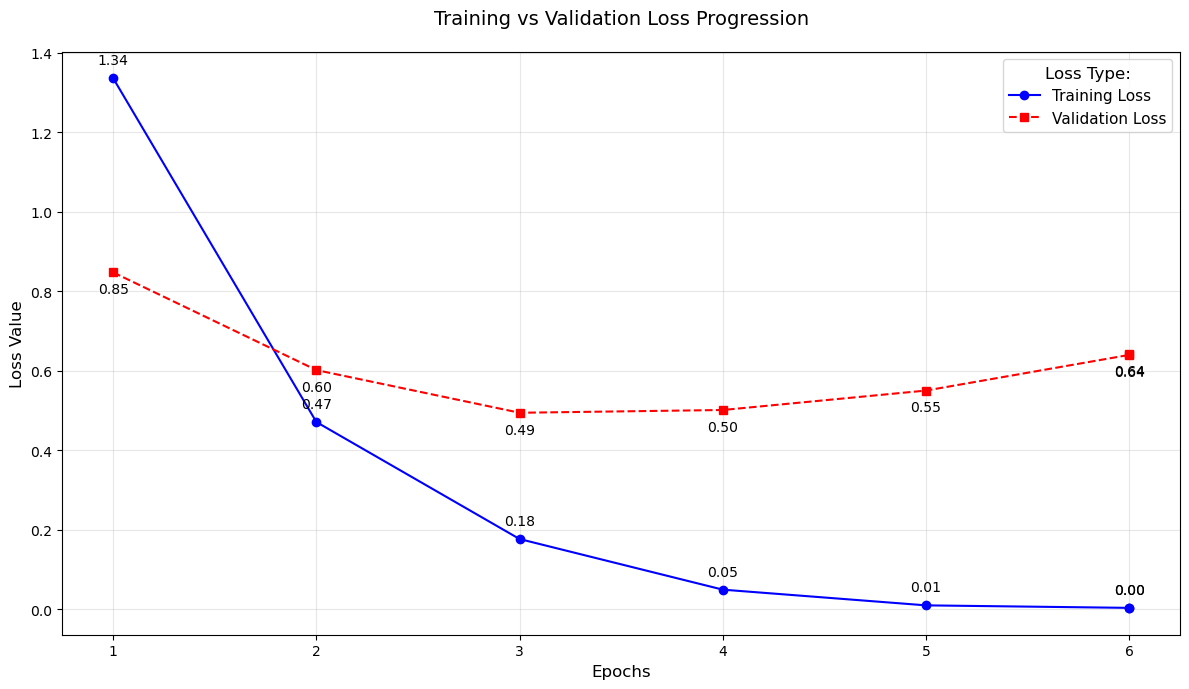

In [ ]:
# Collect training and validation metrics
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_epochs.append(int(log['epoch']))  # Convert to integer epoch
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_epochs.append(int(log['epoch']))  # Convert to integer epoch
        eval_loss.append(log['eval_loss'])

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(train_epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(eval_epochs, eval_loss, 'rs--', label='Validation Loss')

# Add plot descriptions
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Training vs Validation Loss Progression', fontsize=14, pad=20)
plt.legend(title='Loss Type:', title_fontsize=12, fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(min(train_epochs), max(train_epochs)+1, 1.0))

# Add axis labels and data point markers
for x,y in zip(train_epochs, train_loss):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,10), ha='center')
for x,y in zip(eval_epochs, eval_loss):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()

### <a id='toc1_6_2_'></a>[Modell evaluation](#toc0_)

In [ ]:
pred = trainer.predict(hf_dataset.select(test_index))

In [ ]:
id2label = {v:k for k,v in meta['labels'].items()}

#### <a id='toc1_6_2_1_'></a>[Classification report](#toc0_)

In [ ]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       100
           1       0.70      0.47      0.56        15
           2       0.80      0.60      0.69        20
           3       0.76      1.00      0.86        25
           4       0.83      0.90      0.86        69

    accuracy                           0.87       229
   macro avg       0.81      0.78      0.78       229
weighted avg       0.87      0.87      0.86       229



#### <a id='toc1_6_2_2_'></a>[Confusion matrix](#toc0_)

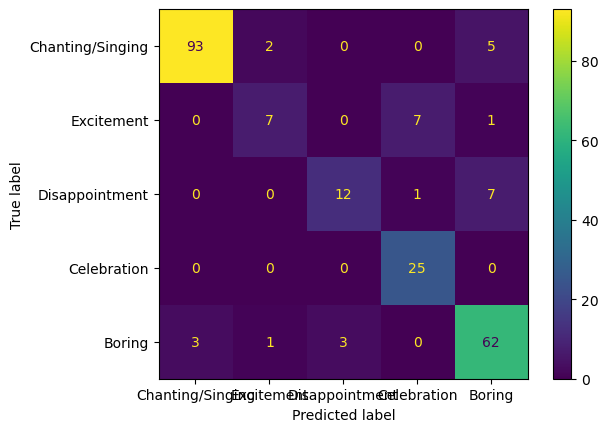

In [ ]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot()

#### <a id='toc1_6_2_3_'></a>[Normalized Confusion matrix](#toc0_)

In [ ]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

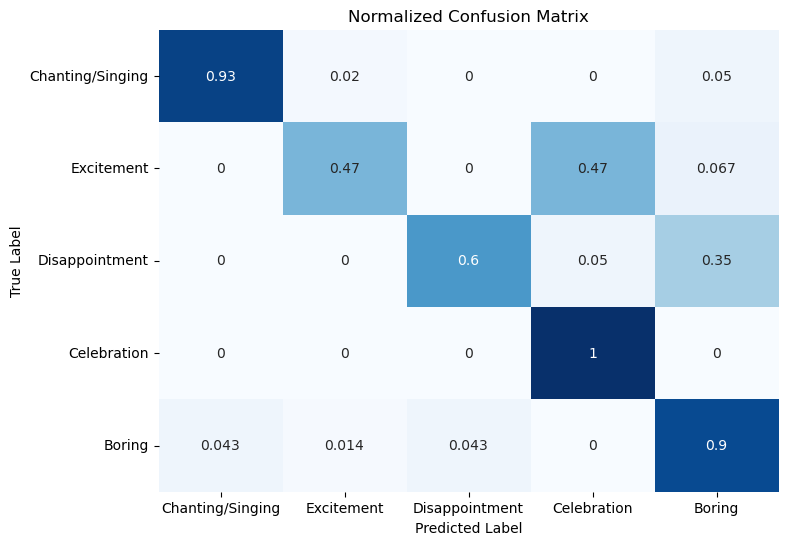

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

As can be seen in the normalized confusion matrix, the data with the label `Celebration` is recognized completely correctly. In addition, the classes `Boring` and `Chanting/Singing` are almost completely correctly classified. 
In contrast, `Dissappointment` is only classified correctly in 60% of cases, as there is more frequent confusion with the `Boring` class. 
`Celebration` is the least well recognized. However, it is striking that these data points are almost exclusively confused with `Celebration`. The poor performance of the model can therefore be explained by the fact that the sounds sound very similar and are also difficult for humans to distinguish (see notebook “0_data_exploration”).

## <a id='toc1_7_'></a>[Conclusion](#toc0_)

There are currently still problems classifying the classes `Excitement` and `Dissapointment` correctly.
Nevertheless, the model already has a very good performance with an **accuracy of 0.87**. In addition, by using the class weighting in the loss function and by optimizing the hyperparameters, the performance of the reference model, which was provided via Moodle (accuracy 0.74), could be significantly increased.